Neural ODEs (based on https://arxiv.org/pdf/1806.07366.pdf):

---

Consider the following equations
$$\frac{dy}{dt} = f(t,y),~~ y(t_0) = y_0.$$
One can write the solution to this ODE using $n$ discretized time steps via Euler's method,
$$y_{n+1} = y_n + f(t_n, y_n)\cdot(t_{n+1} - t_n). $$

>**Enter Residual Networks, or Recurrent Neural Network Decoders!**

The way these models work, input $h_{t+1}$ of $(t+1)^{\text{th}}$ layer  is the sum of the post-activation $f(h_t, \theta_t)$ of $t^{\text{th}}$ layer and inputs $h_t$ to $t^{\text{th}}$ layer. Here, $t \in \{0,\cdots , T \}$, with $h_0$ and $h_T$ respectively the input and output of the model, and $\theta_t$ are the parameters. Let's compare
$$h_{t+1} = h_t + f(h_t, \theta_t)$$
to the previous ODE. This network is analogous to a blacbox ODE solver, with $h_{0}$ and $h_{T}$ respectively equivalent to $y_{t_0}$ and $y_{t_T}$.


----

>*Let's stare at the transformations across layers of a Resnet and vector fields from some ODE solver, for a few seconds.*
![picture](https://drive.google.com/uc?export=view&id=1PPYirzPNZwg4TkRi2EVyVI8lHTsfyVrR)
If one adds many hidden layers in the Resnet and takes smaller steps, it will very nicely approximate the ODE solver on the right.

---

**Example 0: Let's design a simple Residual Network to train on a toy dataset.** (Dataset courtesy, this blog - http://implicit-layers-tutorial.org/neural_odes/)

---

* Import packages (Let's use jax; and for differentiations, we will specify "@jit".)

In [ ]:
import jax.numpy as jnp
import numpy.random as nprand
from jax import grad, jit, vmap
from jax import random

* Start with a fully connected network (multi layer perceptron)

In [ ]:
def fcn(theta, xs):
    for w, b in theta:
      outputs = jnp.dot(xs, w) + b  # Linear transform
      xs = jnp.tanh(outputs)        # Nonlinearity
    return outputs

* Next, use the fully connected network to design a residual network.

In [ ]:
def ResNet(theta, xs, L):
    for i in range(L):
      outputs = fcn(theta, xs) + xs
    return outputs


* Here's a toy dataset, 1D

In [ ]:
input = jnp.reshape(jnp.linspace(-2.5, 2.5, 15), (15, 1))
target = input**3 + 0.1 * input

* Define forward KL divergence loss function

In [ ]:
def L2_loss(theta, xs, ys):
    f_x = ResNet(theta, xs, L)
    return jnp.mean(jnp.sum((f_x - ys)**2, axis=1))


* Define an initializer for parameters

In [ ]:
def init_random_params(scale, N, rng=nprand.RandomState(0)):
    return [(scale * rng.randn(p, q), scale * rng.randn(q))
            for p, q, in zip(N[:-1], N[1:])]


* Define a simple gradient descent optimizer using @jit

In [ ]:
@jit
def ResNet_gd(theta, xs, ys):
    gradients = grad(L2_loss)(theta, xs, ys)
    return [(w - step_size * dw, b - step_size * db)
            for (w, b), (dw, db) in zip(theta, gradients)]

* Define hyperparameters

In [ ]:
L = 4
N = [1, 10, 100, 1]
param_scale = 1.0
step_size = 0.0005
train_iters = 1000

* Initialize the Network, train it, and plot the result.

Text(0, 0.5, 'output')

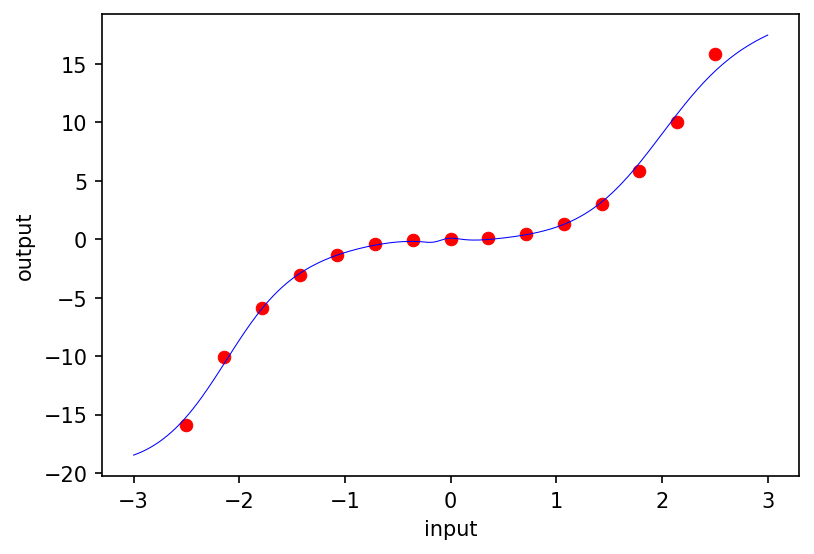

In [ ]:
# initialize parameters first
ResNet_theta = init_random_params(param_scale, N)
# update parameters using gradient descent, loss function
for i in range(train_iters):
    ResNet_theta = ResNet_gd(ResNet_theta, input, target)
# plot results after training
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(input, target, lw=0.5, color='red')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 300), (300, 1))
ax.plot(fine_inputs, ResNet(ResNet_theta, fine_inputs, L), lw=0.5, color='blue')
ax.set_xlabel('input')
ax.set_ylabel('output')


---

**Problem 0: Let's design a toy Neural ODE that can approximate the same data series well enough.**  

---
Hint: An ODE solver is defined as
$$y(t_{n+1}) = y_{t_n} + \int^{t_{n+1}}_{t_n} f(y_{t_n} , t_n , \theta_{t_n}).$$
To design a Neural ODE, one needs to design an optimizer for a scalar valued loss function $L()$, such that
$$L(\,y(t_{n+1})\,) = L \Big( \, y_{t_n} + \int^{t_{n+1}}_{t_n} f(y_{t_n} , t_n , \theta_{t_n}) \, \Big) = L(\, \text{ODESolve}(y(t_n), f, t_n , t_{n+1}, \theta_{t_n}) \, ) .$$

>In this case, we can use "vmap" function for batching.
```
from jax import vmap
batched_neural_ode = vmap(insert_your_Neural_ODE_function_name, in_axes=(None, 0))
```

Let's begin!

----

**Solution to Problem 0**

----

* Let us first concatenate the arguments of $f()$ as a tuple. Next, we can use the same fully connected network module "fcn", for function $f$.

In [ ]:
def f_integrand(y_n, t_n, theta_t_n):
    f_arguments = jnp.hstack([y_n, jnp.array(t_n)])
    return fcn(theta_t_n, f_arguments)

* We choose an ODE solver "odeint" from Jax, next. Please feel free to choose any other ODE solver that you like.

In [ ]:
from jax.experimental.ode import odeint

def NODE(theta_t_n, y_n):
    t0_tT = jnp.array([0.0, 1.0]) # define a tuple of start and end times.
    y0, yT = odeint(f_integrand, y_n, t0_tT, theta_t_n)
    return yT

* Define the loss function next, using "vmap" for batching

In [ ]:
from jax import vmap
batched_NODE = vmap(NODE, in_axes=(None, 0))

def NODE_L2loss(theta, xs, ys):
    f_x = batched_NODE(theta, xs)
    return jnp.mean(jnp.sum((f_x - ys)**2, axis=1))

* Define a simple gradient descent optimizer, as before.

In [ ]:
@jit
def NODE_gd(theta, xs, ys):
    gradients = grad(NODE_L2loss)(theta, xs, ys)
    return [(w - step_size * dw, b - step_size * db)
            for (w, b), (dw, db) in zip(theta, gradients)]


* Initialize and train this Neural ODE on the previous dataset, and plot to compare against the ResNet.

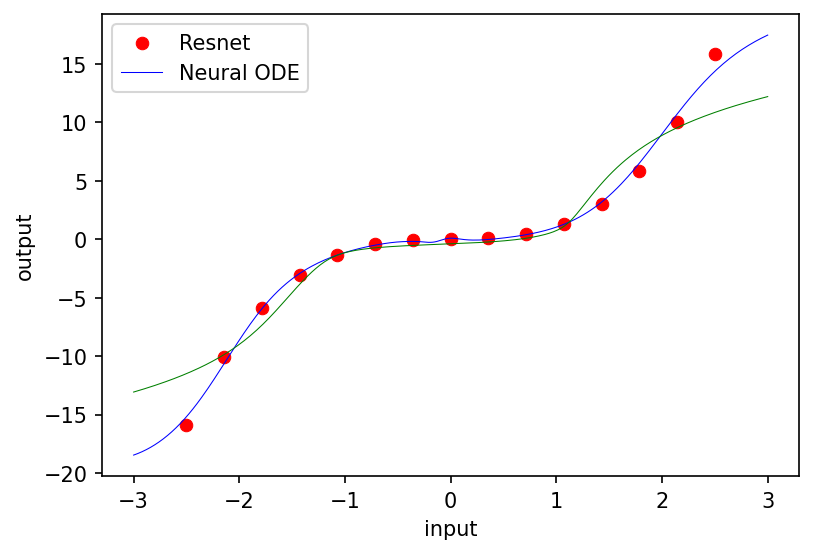

In [ ]:
# Define hyperparameters
NODE_width = [2, 20, 1] # layer sizes
# Initialize parameters.
NODE_theta = init_random_params(param_scale, NODE_width)
# Train the initialized network
for i in range(train_iters):
    NODE_theta = NODE_gd(NODE_theta, input, target)

# Plot this toy neural ODE against previous ResNet for comparison
# Plot resulting model.
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(input, target, lw=0.5, color='red')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 300), (300, 1))
ax.plot(fine_inputs, ResNet(ResNet_theta, fine_inputs, L), lw=0.5, color='blue')
ax.plot(fine_inputs, batched_NODE(NODE_theta, fine_inputs), lw=0.5, color='green')
ax.set_xlabel('input')
ax.set_ylabel('output')
plt.legend(('Resnet', 'Neural ODE'))


***As we can see, this toy neural ODE can approximate some part of the data well, but mostly it's not the best model. Let us look at an actual harmonic oscillator dataset, and design a neural ODE for it as an exercise.***

---



*Problem 1*: Let us consider the differential equation
$$m \, y''(t) + k\, y(t) =0,$$
for $m= 1.4$, $k=1.9$ in appropriate units.

Boundary conditions are $$y(0)=1.2~,~ y(0.47)=0.09~,~y'(1)=0.$$

The solution is $$y(t) = 0.043576 \cos(1.16496 \, t) + 0.101414 \sin(1.16496 \, t)   .$$

> To solve this using Neural ODE, we first note that any arbitrary differential equation of order $n$, for any scalar function $y(t)$,
$$G\big(y(t), y'(t), y''(t), \cdots , y^{(n)}(t),t \big) = 0$$
can be mapped into a system of first order differential equations
$$y'_1(t) = y_2(t),\\
y'_2(t) = y_3(t), \\
\vdots \\
y'_n(t) = G^*\big(y(t), y'(t), y''(t), \cdots , y^{(n)}(t),t \big).
$$
Here, $G^*$ is obtained by solving $G$ for $y^{(n)}(t)$.

Now that this second order differential equation has been recast in terms of two different first order differential equations, our Neural ODE will need to converge to two different data series $\{y'(t), y(t) \}$ simultaneously.

Let's stat building it up!

---

Hint (optional): Use Tensorflow Keras, MSE loss, Adam optimizer.

----

**Solution to Problem 1**

----

* Import packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

* Generate training data

In [ ]:
# harmonic oscillator solution y(t)
def y(t):
    return 0.043576*np.cos(1.16496*t) + 0.101414*np.sin(1.16496*t)

# first derivative of y(t)
def y_prime(t):
    return 0.118144*np.cos(1.16496*t) - 0.0507645*np.sin(1.16496*t)

# generate random training points in the interval t=0...40
x_train = np.random.rand(200)*30
y_train = np.array([y(x_train), y_prime(x_train)]).T

* Create and compile a simple 2 hidden layer network with tanh activation and each layer size 100.

In [ ]:
ODE_model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation=tf.nn.tanh, input_shape=(1,)),
    tf.keras.layers.Dense(100, activation=tf.nn.tanh),
    tf.keras.layers.Dense(2)
])
ODE_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.MeanSquaredError()
)

Next, train this model.

In [ ]:
# learning is noisy, keep best parameters during training
checkpoint = tf.keras.callbacks.ModelCheckpoint("weights",
    save_weights_only=True, monitor="loss", verbose=1, save_best_only=True
)
history = ODE_model.fit(x_train, y_train, epochs=4500, batch_size=100,
    callbacks=[checkpoint])
ODE_model.load_weights("weights")

x = np.linspace(0,30,1000)
y = y(x)
y_prime = y_prime(x)
y_yprime = ODE_model.predict(x) # first axis is y(t), second axis is yprime(t)

Streaming output truncated to the last 5000 lines.
Epoch 2846/4500
1/2 [==============>...............] - ETA: 0s - loss: 0.0026
Epoch 2846: loss did not improve from 0.00213
2/2 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 2847/4500
1/2 [==============>...............] - ETA: 0s - loss: 0.0022
Epoch 2847: loss did not improve from 0.00213
2/2 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 2848/4500
1/2 [==============>...............] - ETA: 0s - loss: 0.0030
Epoch 2848: loss did not improve from 0.00213
2/2 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 2849/4500
1/2 [==============>...............] - ETA: 0s - loss: 0.0031
Epoch 2849: loss did not improve from 0.00213
2/2 [==============================] - 0s 10ms/step - loss: 0.0029
Epoch 2850/4500
1/2 [==============>...............] - ETA: 0s - loss: 0.0027
Epoch 2850: loss did not improve from 0.00213
2/2 [==============================] - 0s 6ms/step - loss: 0.003

* Plot trained output against analytic harmonic oscillator solution.

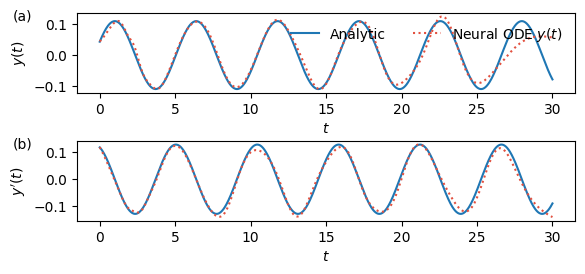

In [ ]:
fig = plt.figure(figsize=(6,4))
c1 = "#1F77B4"
c2 = "#E25140"
plt.subplots_adjust(left=0.12, right=0.95, top=0.95, hspace=0.6)

ax = plt.subplot(3, 1, 1)
ax.annotate('(a)', xycoords="axes fraction", xy=(-0.13,0.9))
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.plot(x, y, color=c1, label="Analytic")
plt.plot(x, y_yprime[:,0], color=c2, linestyle="dotted", label="Neural ODE $y(t)$")
plt.legend(loc='upper right', frameon=False, ncol=2)

ax = plt.subplot(3, 1, 2)
ax.annotate('(b)', xycoords="axes fraction", xy=(-0.13,0.9))
plt.xlabel("$t$")
plt.ylabel("$y'(t)$")
plt.plot(x, y_prime, color=c1, label="Analytic")
plt.plot(x, y_yprime[:,1], color=c2, linestyle="dotted", label="$y'(t)$")